<a href="https://colab.research.google.com/github/hzeybek/doktora/blob/main/doktora_isco_classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Doktora/kariyernet_is_ilanlari.csv',sep='|')
df = df.loc[:,['title','isco08']]
df = df.drop_duplicates()
df['isco08'] = df['isco08'].astype(int)
df['isco08'].unique()
df = df[df['isco08'].map(df['isco08'].value_counts()) >5]
df['isco08'].unique()
df.groupby('isco08').size()
le = LabelEncoder()
df['encoded_categories'] = le.fit_transform(df['isco08'])

In [ ]:
stop_words = ['g','kg','gr','adet','l','xl','ml','xg','tb','x','m','l','rfa','k','kg*','xml','prm','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','r','s','t','u','v','y','z','ç','ü','ö']
def removeStopWords(sentence):
    for word in stop_words:
        token = " " + word + " "
        sentence = sentence.replace(token, " ")
    return sentence

In [ ]:
def removeOneLetters(sentence):
    sentence = " "+ sentence+" "
    for word in sentence.split(" "):
        if len(word)==1:
            token = " " + word + " "
            sentence = sentence.replace(token," ")
    return sentence.strip()

In [ ]:
[removeOneLetters(x) for x in df['title']]

['Şantiye Şefi',
 'Saha Mühendisi',
 'İnşaat Mühendisi',
 'Teknik Ofis Mühendisi',
 'İnce İşler Şefi',
 'Proje Müdürü',
 'İhale Hazırlık Mühendisi',
 'Akdeniz Bölge Gayrimenkul Değerleme Uzmanı',
 'Hakediş-Kesin Hesap Yöneticisi',
 'Yüksek İnşaat Mühendisi',
 'Hakediş Mühendisi',
 'Makine Mühendisi',
 'Tasarım Mühendisi',
 'Makine Tasarım Mühendisi',
 'Makine Bakım Mühendisi',
 'Satış Şefi',
 'Talaşlı İmalat Satış Mühendisliği',
 'Üretim Mühendisi',
 'Dizayn Donatım Mühendisi',
 'Mekanik Bakım Mühendisi',
 'Mekanik Analiz Mühendisi',
 'Kaynak Mühendisi',
 'Mekanik Tasarım Mühendisi',
 'Kalite Kontrol Mühendisi',
 'İş Planlama Mühendisi',
 'Mekanik İşler Mühendisi',
 'Bakım Onarım Mühendisi',
 'CAD Cam Mühendisi',
 'Periyodik Kontrol Uzmanı',
 'Araştırma Geliştirme Arge Mühendisi',
 'Kimya Laboratuvar Uzmanı',
 'AR-GE Uzmanı',
 'Kimya Mühendisi',
 'AR-GE Farmasötik Teknoloji Geliştirme Analisti',
 'Kimyager Kimya Mühendisi',
 'Kalite Kontrol Uzman Yardımcısı',
 'Laboratuvar Müdürü',
 'K

In [ ]:
df = df[df['title'].str.len()>1]
df['title'] = [x.lower() for x in df['title']]
df['title']=[removeStopWords(x) for x in df['title']]
df['title']= [removeOneLetters(x) for x in df['title']]
df.head(100)

,title,isco08,encoded_categories
0,şantiye şefi,2142,1
1,saha mühendisi,2142,1
2,i̇nşaat mühendisi,2142,1
5,teknik ofis mühendisi,2142,1
7,i̇nce i̇şler şefi,2142,1
...,...,...,...
151,ios developer,2513,9
155,veri tabanı uzmanı,2521,10
156,yazılım geliştirme mühendisi,2512,8
157,software engineer integration team,2512,8


In [ ]:
df.count()

title                 384
isco08                384
encoded_categories    384
dtype: int64

In [ ]:
X = df['urun_adi'].astype(str)
Y = df['coicop']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
#X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.05,random_state=42)
max_len = 20
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(df.title, df.encoded_categories, random_state=42, stratify=df.encoded_categories,test_size=0.2)   

In [ ]:
max_words = 4500
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
word_index = tok.word_index
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
word_index

{'1': 237,
 '5': 236,
 'a': 238,
 'adana': 179,
 'akdeniz': 155,
 'akım': 78,
 'akışkanlar': 177,
 'alanında': 169,
 'alma': 112,
 'altyapı': 193,
 'analisti': 68,
 'analiz': 58,
 'android': 82,
 'ankara': 41,
 'antalya': 93,
 'ar': 33,
 'araştırma': 84,
 'arge': 36,
 'back': 227,
 'backend': 45,
 'bakım': 10,
 'balıkesir': 210,
 'bandırma': 140,
 'based': 246,
 'baymina': 181,
 'beton': 263,
 'bilen': 153,
 'bilgisayar': 170,
 'birim': 280,
 'biyomedikal': 211,
 'borulama': 232,
 'boyahane': 172,
 'bölge': 156,
 'cad': 252,
 'cam': 253,
 'cloud': 102,
 'control': 242,
 'csharp': 116,
 'data': 60,
 'deployment': 221,
 'destek': 80,
 'developer': 4,
 'development': 115,
 'devops': 90,
 'devreye': 111,
 'değerleme': 29,
 'değerlendirmesi': 131,
 'dinamiği': 178,
 'dizayn': 120,
 'dokümantasyon': 196,
 'donanım': 92,
 'donatım': 256,
 'e': 157,
 'eba': 225,
 'elektrik': 3,
 'elektronik': 14,
 'elemanı': 209,
 'embedded': 122,
 'end': 52,
 'endüstri': 83,
 'enerji': 194,
 'engineer': 13,
 

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(12,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
import tensorflow as tf
model = RNN()
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 50)           225000    
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 12)                3084  

In [ ]:
'''history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=20,
          validation_split=0.1,callbacks=[EarlyStopping(monitor='val_accuracy',min_delta=0.0001)])'''
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=20,
          validation_split=0.1)

Epoch 1/20
3/3 [==============================] - 5s 737ms/step - loss: 2.4817 - accuracy: 0.1123 - val_loss: 2.4705 - val_accuracy: 0.2258
Epoch 2/20
3/3 [==============================] - 2s 477ms/step - loss: 2.4619 - accuracy: 0.2500 - val_loss: 2.4444 - val_accuracy: 0.1935
Epoch 3/20
3/3 [==============================] - 2s 456ms/step - loss: 2.4209 - accuracy: 0.1957 - val_loss: 2.3766 - val_accuracy: 0.0968
Epoch 4/20
3/3 [==============================] - 2s 460ms/step - loss: 2.3566 - accuracy: 0.1630 - val_loss: 2.3891 - val_accuracy: 0.0968
Epoch 5/20
3/3 [==============================] - 2s 458ms/step - loss: 2.3125 - accuracy: 0.1920 - val_loss: 2.3811 - val_accuracy: 0.0645
Epoch 6/20
3/3 [==============================] - 2s 458ms/step - loss: 2.3165 - accuracy: 0.2029 - val_loss: 2.3918 - val_accuracy: 0.0645
Epoch 7/20
3/3 [==============================] - 2s 468ms/step - loss: 2.3227 - accuracy: 0.1630 - val_loss: 2.4270 - val_accuracy: 0.0645
Epoch 8/20
3/3 [====

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
model.evaluate(test_sequences_matrix,Y_test)

3/3 [==============================] - 0s 56ms/step - loss: 1.9201 - accuracy: 0.3636


[1.9200526475906372, 0.3636363744735718]

In [ ]:
X_train

In [ ]:
tok.fit_on_texts(X_test)
sequences = tok.texts_to_sequences(X_test)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
y_predicted = model.predict(sequences_matrix)

In [ ]:
a = [np.argmax(y_pred) for y_pred in y_predicted]

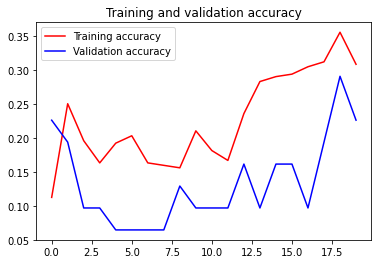

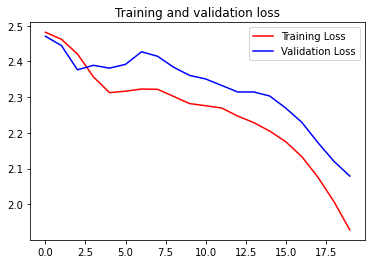

In [ ]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
np.argmax(Y_test)

In [ ]:
predicted_coicops = le.inverse_transform(a)

In [ ]:
predicted_coicops

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
import sklearn
asa = sklearn.metrics.confusion_matrix(Y_test, a)

In [ ]:
from numpy import savetxt
savetxt("D:\\asa.txt",asa,delimiter=',')

In [ ]:
type(a)

In [ ]:
Y_train

In [ ]:
le.inverse_transform(Y_test)

In [ ]:
X_test

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,Y_test)


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
Y_predicted = model.predict(test_sequences_matrix)
Y_pred = [np.argmax(a) for a in Y_predicted]


Y_test_list = sum(Y_test.tolist(),[])


In [ ]:
Y_test_list

In [ ]:
Y_pred

In [ ]:
le.inverse_transform(Y_pred)

In [ ]:
le.inverse_transform(Y_test_list)

In [ ]:
X_test

In [ ]:
X_test_2=['eker yoğurt']

In [ ]:
test_sequences2 = tok.texts_to_sequences(X_test_2)
test_sequences_matrix2 = sequence.pad_sequences(test_sequences2,maxlen=max_len)

In [ ]:
Y_predicted2 = model.predict(test_sequences_matrix2)

In [ ]:
Y_predicted2

In [ ]:
Y_pred2 = [np.argmax(a) for a in Y_predicted2]

In [ ]:
le.inverse_transform(Y_pred2)

In [ ]:
stop_words = ['g','kg','gr','adet','l','x','ml','xg','tb','x','m','l','rfa','k','kg*','xml','prm']
def removeStopWords(sentence):
    for word in stop_words:
        token = " " + word + " "
        sentence = sentence.replace(token, " ")
    return sentence
    

In [ ]:
headers = ['coicop', 'urun_adi']
dtypes = {'coicop': 'str', 'urun_adi': 'str'}
df = pd.read_csv('D:\\TuikUser\\39688123572\\Desktop\\barkod.csv',delimiter='@',header=None, names=headers,dtype=dtypes)
import locale
locale.setlocale(locale.LC_ALL, 'tr_TR.utf8')
df = df[df['coicop'].str.len()==5]
df = df[df['urun_adi'].str.len()>1]
df['urun_adi'] = [x.lower() for x in df['urun_adi']]
df['urun_adi']=[removeStopWords(x) for x in df['urun_adi']]
df.head()

In [ ]:
X = df['urun_adi'].astype(str)
Y = df['coicop']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=42)
max_words = 4000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
word_index = tok.word_index
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(68,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
import tensorflow as tf
model = RNN()
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

In [ ]:
%load_ext tensorboard

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
le.inverse_transform(Y_test)

In [ ]:
accuracy_score(y_pred=predicted_coicops, y_true=le.inverse_transform(Y_test))

In [ ]:
predicted_coicops

In [ ]:
y_predicted = model.predict(test_sequences_matrix)

In [ ]:
y_predicted = [np.argmax(y) for y in y_predicted]

In [ ]:
y_predicted

In [ ]:
Y_test

In [ ]:
accuracy_score(y_pred=y_predicted,y_true=Y_test)

In [ ]:
from sklearn.metrics import f1_score


In [ ]:
f1_score(y_pred=y_predicted,y_true=Y_test, average='micro')

ValueError: ignored

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Ali osman SVM kodu

import pandas as pd
import locale
import string
import nltk
import time

df = pd.read_csv('/content/drive/MyDrive/Doktora/kariyernet_is_ilanlari.csv',sep='|')
df = df.loc[:,['title','isco08']]
df = df.drop_duplicates()
df['isco08'] = df['isco08'].astype(int)
df['isco08'].unique()
df = df[df['isco08'].map(df['isco08'].value_counts()) >5]
df['isco08'].unique()
df.groupby('isco08').size()
le = LabelEncoder()
df['encoded_categories'] = le.fit_transform(df['isco08'])

#len(df['coicop'].unique())

X_orj = df['title'].astype(str)
Y = df['encoded_categories']

from collections import Counter
c= Counter(X_orj)


def preprocess(text):
    #Remove punctuation characters    
    text= " ".join("".join([" " if ch in string.punctuation else ch for ch in str(text)]).split())
    
    #Extract Tokens
    tokens= [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    #Convert to lowercase
    tokens= [word.lower() for word in tokens]
        
    #keeping only  the words haing at least three characters
    #tokens=[word for word in tokens if len(word)>=2]
    
    return tokens

X = []
for row in X_orj:
    X.append(preprocess(row))

#splitting train and test data
from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42 )
x_train,x_test,y_train,y_test = train_test_split(X, Y, random_state=42, stratify=df.encoded_categories,test_size=0.2)   
#creating tfidfVektor
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm='l2', max_features=4000,tokenizer=lambda x: x,preprocessor=lambda x: x,token_pattern=None)
x_train_tfidf= vectorizer.fit_transform(x_train).todense()
x_test_tfidf= vectorizer.transform(x_test).todense()
x_train_tfidf.shape

#fitting by classificiaton
from sklearn.svm import LinearSVC
start = time.time()
clf = LinearSVC(loss='hinge', C=1, max_iter=1000)
clf = clf.fit(x_train_tfidf, y_train)
last=time.time()
print(last - start)

#prediction
ytrain_nb_predicted= clf.predict(x_train_tfidf)
ytest_nb_predicted= clf.predict(x_test_tfidf)

#Assesments
from sklearn.metrics import classification_report,accuracy_score,f1_score

#calculating accuracy and f-score for test set
test_acc = accuracy_score(y_test, ytest_nb_predicted)
print("Accuracy for test data=", round(test_acc,3))
test_f1 = f1_score(y_test, ytest_nb_predicted, average='macro')
print("f1 score for test data=", round(test_f1,3))

print("Test Classification Report")
print(classification_report(y_test,ytest_nb_predicted))

#confusion matrix for test set
print("Confusion matrix for test set")
confusuion_matrix=pd.crosstab(ytest_nb_predicted,y_test, rownames=["Predicted"], colnames=["Actual"])
#confusuion_matrix.to_csv('D:\\TuikUser\\39688123572\\Desktop\\svm_output.csv')




0.014637947082519531
Accuracy for test data= 0.883
f1 score for test data= 0.907
Test Classification Report
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         2
           3       0.83      0.83      0.83        12
           4       0.75      1.00      0.86         6
           5       1.00      1.00      1.00         3
           6       1.00      0.70      0.82        10
           7       0.80      0.80      0.80         5
           8       0.86      1.00      0.92        12
           9       1.00      0.88      0.93         8
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         1

    accuracy                           0.88        77
   macro avg       0.91      0.91      0.91        77
weighted avg       0.89      0.88      0.88        77

Confusion matrix for test

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
# Ali osman SVM kodu

import pandas as pd
import locale
import string
import nltk
import time


headers = ['coicop', 'urun_adi']
dtypes = {'coicop': 'str', 'urun_adi': 'str'}
df = pd.read_csv('D:\\TuikUser\\39688123572\\Desktop\\barkod.csv',delimiter='@',header=None, names=headers,dtype=dtypes)

locale.setlocale(locale.LC_ALL, 'tr_TR.utf8')
df = df[df['coicop'].str.len()==5]
df = df[df['urun_adi'].str.len()>1]
#len(df['coicop'].unique())

X_orj = df['urun_adi'].astype(str)
Y = df['coicop']

from collections import Counter
c= Counter(X_orj)


def preprocess(text):
    #Remove punctuation characters    
    text= " ".join("".join([" " if ch in string.punctuation else ch for ch in str(text)]).split())
    
    #Extract Tokens
    tokens= [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    #Convert to lowercase
    tokens= [word.lower() for word in tokens]
        
    #keeping only  the words haing at least three characters
    #tokens=[word for word in tokens if len(word)>=2]
    
    return tokens

X = []
for row in X_orj:
    X.append(preprocess(row))

#splitting train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42 )

#creating tfidfVektor
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm='l2', max_features=4000,tokenizer=lambda x: x,preprocessor=lambda x: x,token_pattern=None)
x_train_tfidf= vectorizer.fit_transform(x_train).todense()
x_test_tfidf= vectorizer.transform(x_test).todense()
x_train_tfidf.shape

#fitting by classificiaton
from sklearn.svm import LinearSVC
start = time.time()
clf = LinearSVC(loss='hinge', C=1, max_iter=1000)
clf = clf.fit(x_train_tfidf, y_train)
last=time.time()
print(last - start)

#prediction
ytrain_nb_predicted= clf.predict(x_train_tfidf)
ytest_nb_predicted= clf.predict(x_test_tfidf)

#Assesments
from sklearn.metrics import classification_report,accuracy_score,f1_score

#calculating accuracy and f-score for test set
test_acc = accuracy_score(y_test, ytest_nb_predicted)
print("Accuracy for test data=", round(test_acc,3))
test_f1 = f1_score(y_test, ytest_nb_predicted, average='macro')
print("f1 score for test data=", round(test_f1,3))

print("Test Classification Report")
print(classification_report(y_test,ytest_nb_predicted))

#confusion matrix for test set
print("Confusion matrix for test set")
confusuion_matrix=pd.crosstab(ytest_nb_predicted,y_test, rownames=["Predicted"], colnames=["Actual"])
confusuion_matrix.to_csv('D:\\TuikUser\\39688123572\\Desktop\\svm_output.csv')



